# MLBD : Project on the music dataset

The base subject is : Predicting a playlist that satisfies group members (e.g., to decide the music to play in a party). By playlist we mean a set of artists.

Research questions : 
- Can we generate a playlist of artists for multiple users based on what they listened?

### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Load the data

In [3]:
DATA_FOLDER = 'data/'
TOP_FOLDER = DATA_FOLDER + 'lastfm-dataset-360k/'
TIMELINE_FOLDER = DATA_FOLDER + 'lastfm-dataset-1k/'

#Using just the artists
top_user = pd.read_csv(TOP_FOLDER + 'usersha1-profile.tsv', sep = '\t', error_bad_lines = False, header = None)
top_data = pd.read_csv(TOP_FOLDER + 'usersha1-artmbid-artname-plays.tsv', sep = '\t', error_bad_lines = False, header = None)

#timeline_user = pd.read_csv(TIMELINE_FOLDER + 'userid-profile.tsv', sep = '\t', error_bad_lines = False, header = 0)
#timeline_data = pd.read_csv(TIMELINE_FOLDER + 'userid-timestamp-artid-artname-traid-traname.tsv', sep = '\t', error_bad_lines = False, header = None)

In [4]:
top_user.head()

,0,1,2,3,4
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


In [5]:
top_data.head()

,0,1,2,3
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


### 3. Exploratory data analysis

As we see, the columns have not proper names, we reformat them in this cell:

In [6]:
#Need to rename the columns
top_user.rename(columns = {0 : 'ID', 1 : 'Gender', 2 : 'Age', 3 : 'Country', 4 : 'Registered'}, inplace = True)
top_data.rename(columns = {0 : 'ID', 1 : 'Artist_ID', 2 : 'Artist', 3 : 'Plays'}, inplace = True)

In [7]:
top_user.shape

(359347, 5)

In [8]:
top_data.shape

(17535655, 4)

We have 359'347 users in the users dataset and 17'535'655 entries of type (user, Artist, Plays)

In [9]:
# we'll check the number of NaNs for each dataset
print(top_user.isna().sum(), '\n')
print(top_data.isna().sum(), '\n')

ID                0
Gender        32775
Age           74900
Country           0
Registered        0
dtype: int64 

ID                0
Artist_ID    226137
Artist          204
Plays             0
dtype: int64 



There is no missing entries for the user dataset, however we miss a lot of artist_ID and some artists name. We therefore remove the 204 artists with no name as there we can't recommand them.

In [10]:
to_drop = top_data[top_data['Artist'].isna()].index
top_data = top_data.drop(to_drop)

Let's see how many artists we have and users that have at least listen to one music:

In [11]:
print(f"The dataset has {len(top_data.groupby('Artist').count())} artists")

The dataset has 292363 artists


In [12]:
nb_users_in_top_data = len(top_data.groupby('ID').count())
print(f"The music dataset has {nb_users_in_top_data} users, meaning that {359347-nb_users_in_top_data} did not listen to anything and have therefore no matching entries")

The music dataset has 358868 users, meaning that 479 did not listen to anything and have therefore no matching entries


Now we look at the number of users that have listened to one artist

In [13]:
artists_nb_users_listen= top_data.groupby(['Artist']).size().sort_values(ascending = True).reset_index(name = 'nb_users')
# we check how many times an artist occurs in dataset
artists_nb_users_listen

,Artist,nb_users
0,04)],1
1,jim stringer & the am band,1
2,jim sturgess +,1
3,jim sturgess and dana fuchs,1
4,jim sturgess/jim sturgess,1
...,...,...
292358,muse,46954
292359,red hot chili peppers,48924
292360,coldplay,66658
292361,the beatles,76245


In [14]:
artists_nb_users_listen.describe()

,nb_users
count,292363.000000
mean,59.978352
std,672.472347
min,1.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,77254.000000


As expected, the distribution is exponential. More than 25% of the artists have been listened only by 1 user, 50% by 2, 75% by 8.

As we want to recommend artists to a group of users, and those artists are listened by too few of them, we argue that we can remove some of them.

Text(0.5, 1.0, 'Zoom on artists having more than 10 listeners')

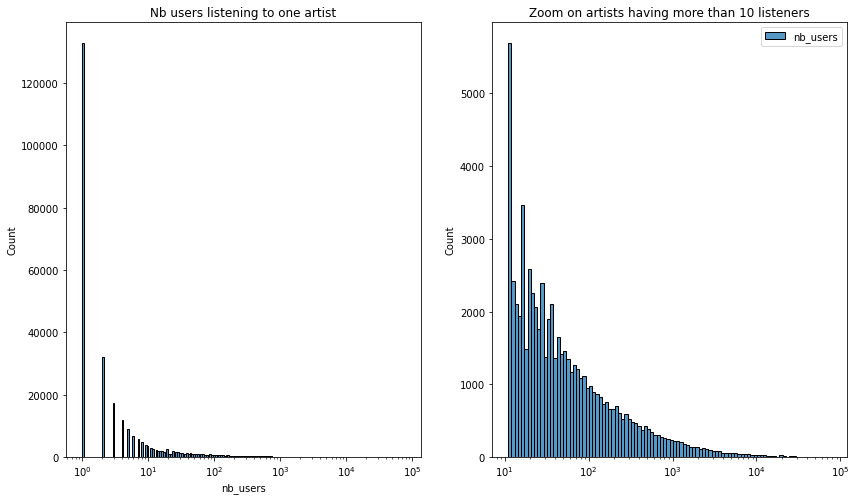

In [15]:
fig, ax = plt.subplots(1, 2,figsize = (14,8))
sns.histplot(artists_nb_users_listen['nb_users'], log_scale = True, ax = ax[0])
ax[0].set_title("Nb users listening to one artist")
sns.histplot(data = artists_nb_users_listen[artists_nb_users_listen['nb_users']>10], log_scale = True, ax = ax[1])
ax[1].set_title("Zoom on artists having more than 10 listeners")

We take artists that have been listened by at least 10 users.

In [16]:
more_than_10_listeners = artists_nb_users_listen[artists_nb_users_listen['nb_users'] > 10]

In [17]:
top_data = top_data[top_data['Artist'].isin(more_than_10_listeners.Artist)]
top_data

,ID,Artist_ID,Artist,Plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
...,...,...,...,...
17535650,"sep 20, 2008",7ffd711a-b34d-4739-8aab-25e045c246da,turbostaat,12
17535651,"sep 20, 2008",9201190d-409f-426b-9339-9bd7492443e2,cuba missouri,11
17535652,"sep 20, 2008",e7cf7ff9-ed2f-4315-aca8-bcbd3b2bfa71,little man tate,11
17535653,"sep 20, 2008",f6f2326f-6b25-4170-b89d-e235b25508e8,sigur rós,10


From this we looses more than 500'000 entries in the dataset

#### Now look at the users

In [18]:
users_nb_artists_listen = top_data.groupby('ID').size().sort_values().reset_index(name = 'nb_artists_listen')

In [19]:
users_nb_artists_listen.describe()

,nb_artists_listen
count,358847.000000
mean,47.383779
std,8.680324
min,1.000000
25%,44.000000
50%,48.000000
75%,50.000000
max,159.000000


Interestingly, we see that, although we have a lot of artists, users tend to listen to only a few of them. In average, a users has listened to 49 different artists with the quantiles being near from each other which is good.

Let's now see from where our users come from. It's possible that the origin of the user has an impact on what he listens

In [20]:
nb_users_per_country = top_user.groupby('Country').size().reset_index(name = 'nb_users')

In [21]:
nb_users_per_country = nb_users_per_country.sort_values('nb_users')

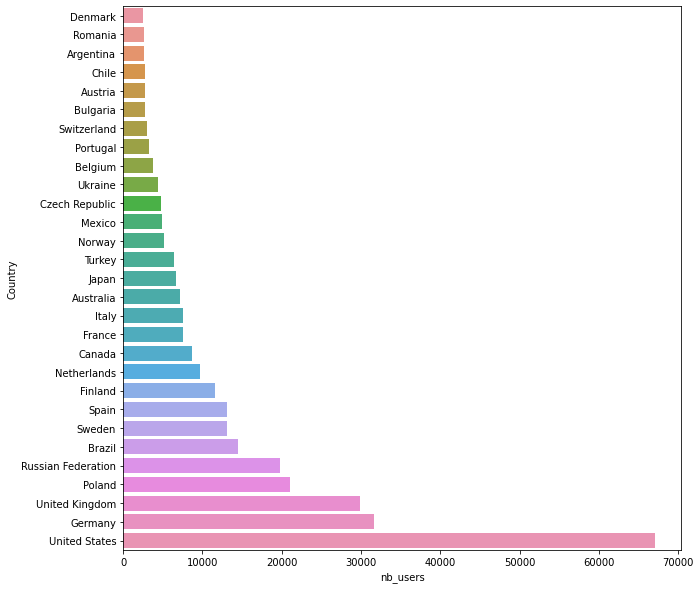

In [22]:
#Only plotting the countries with more than 2000 users in the database
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(ax= ax, data = nb_users_per_country[nb_users_per_country['nb_users']>2000], x = 'nb_users', y = 'Country', )

We can observe that most of our users come from the United States, Germany and the United Kingdom. More generally, we have a lot of european music culture with the exception of Brazil, Japan, Turkey, Mexico, Chile and Argentinia. We will therefore have that the most listened artists come from this culture. 

Let's now try to merge the two dataset together to continue the exploration

In [23]:
top_merged = top_data.merge(top_user, left_on='ID', right_on='ID')
top_merged = top_merged.drop(columns=['Artist_ID', 'Registered']) ##Drop when the users was registered and the artist_ID

In [24]:
# !!! it seems that we lose approximetely 100k users by merging two datasets above. 
# But I guess we can't do anything with that, but probably it's good to mention it in eda ~rap

# We decide to eliminate users, which have listened to less than 10 favourite artists (We'll use trivial recommendation for them)
top_merged_IDs = top_merged.groupby(['ID']).size().reset_index()
users_id = top_merged_IDs[top_merged_IDs[0] > 10]['ID']
top_merged = top_merged[top_merged['ID'].isin(users_id)]

Let's see if artists are more listened to one country or another

In [25]:
artists_per_country = top_merged[['Artist', 'Country', 'ID', 'Plays']].groupby(['Artist','Country']).agg({'ID': len,
                             'Plays': 'sum'}).rename(columns = {'ID':'nb_users'})

In [26]:
artists_per_country

nb_users  Plays
Artist     Country                             
!!!        American Samoa              1   1004
           Andorra                     1     22
           Antarctica                  2    309
           Antigua and Barbuda         1     29
           Argentina                  14   1788
...                                  ...    ...
Ｖｅｒｓａｉｌｌｅｓ Poland                      1     32
           Russian Federation          1      4
           Singapore                   1     65
           Sweden                      1     23
           United States               4    260

[1314861 rows x 2 columns]

With this, we can also look at the most listened artist in one country:

In [27]:
top1_artist_per_country = artists_per_country.unstack(1, fill_value = 0)

In [28]:
top1_artist_per_country = top1_artist_per_country.reset_index()
top1_artist_per_country

Artist    nb_users                                         \
Country                Afghanistan Albania Algeria American Samoa Andorra   
0                  !!!           0       0       0              1       1   
1        !action pact!           0       0       0              0       0   
2             !deladap           0       0       0              0       0   
3             !distain           0       0       0              0       0   
4           !t.o.o.h.!           0       0       0              0       0   
...                ...         ...     ...     ...            ...     ...   
64332             ＬｕＬｕ           0       0       0              0       0   
64333                Ｍ           0       0       0              0       0   
64334        ＭＡＮＮＥＱＵＩＮ           0       0       0              0       0   
64335    Ｓｃｈｗａｒｚ　Ｓｔｅｉｎ           0       0       0              0       0   
64336       Ｖｅｒｓａｉｌｌｅｓ           0       0       0              0       0   

                                                        ...   Plays            \
Country Angola Anguilla Antarctica Antigua and Barbuda  ... Vanuatu Venezuela   
0            0        0          2                   1  ...       0      1744   
1            0        0          0                   0  ...       0         0   
2            0        0          0                   0  ...       0         0   
3            0        0          0                   0  ...       0         0   
4            0        0          1                   0  ...       0       389   
...        ...      ...        ...                 ...  ...     ...       ...   
64332        0        0          0                   0  ...       0         0   
64333        0        0          0                   0  ...       0         0   
64334        0        0          0                   0  ...       0         0   
64335        0        0          1                   0  ...       0         0   
64336        0        0          0                   0  ...       0         0   

                                                               \
Country Viet Nam Virgin Islands, British Virgin Islands, U.s.   
0              0                       0                    0   
1              0                       0                    0   
2              0                       0                    0   
3              0                       0                    0   
4              0                       0                    0   
...          ...                     ...                  ...   
64332          0                       0                    0   
64333          0                       0                    0   
64334          0                       0                    0   
64335          0                       0                    0   
64336          0                       0                    0   

                                                                
Country Wallis and Futuna Western Sahara Yemen Zambia Zimbabwe  
0                     283              0     0      0        0  
1                       0              0     0      0        0  
2                       0              0     0      0        0  
3                       0              0     0      0        0  
4                       0              0     0      0        0  
...                   ...            ...   ...    ...      ...  
64332                   0              0     0      0        0  
64333                   0              0     0      0        0  
64334                   0              0     0      0        0  
64335                   0              0     0      0        0  
64336                   0              0     0      0        0  

[64337 rows x 479 columns]

In [29]:
top1_artist_per_country = top1_artist_per_country.set_index(top1_artist_per_country['Artist']).drop(columns = 'Artist')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [30]:
for country in top1_artist_per_country['nb_users']:
    print(f"Most listened artist in {country}: {top1_artist_per_country['nb_users'][country].idxmax()}, with {top1_artist_per_country['nb_users'][country].max()} users")

Most listened artist in Afghanistan: radiohead, with 12 users
Most listened artist in Albania: metallica, with 14 users
Most listened artist in Algeria: [unknown], with 7 users
Most listened artist in American Samoa: radiohead, with 9 users
Most listened artist in Andorra: obrint pas, with 39 users
Most listened artist in Angola: beyoncé, with 8 users
Most listened artist in Anguilla: muse, with 5 users
Most listened artist in Antarctica: radiohead, with 76 users
Most listened artist in Antigua and Barbuda: radiohead, with 9 users
Most listened artist in Argentina: the beatles, with 812 users
Most listened artist in Armenia: the beatles, with 13 users
Most listened artist in Aruba: the beatles, with 11 users
Most listened artist in Australia: radiohead, with 1984 users
Most listened artist in Austria: die Ärzte, with 572 users
Most listened artist in Azerbaijan: the beatles, with 16 users
Most listened artist in Bahamas: radiohead, with 10 users
Most listened artist in Bahrain: radiohe

Most listened artist in Mayotte: arctic monkeys, with 3 users
Most listened artist in Mexico: radiohead, with 1578 users
Most listened artist in Micronesia, Federated States of: radiohead, with 8 users
Most listened artist in Moldova: coldplay, with 42 users
Most listened artist in Monaco: arctic monkeys, with 7 users
Most listened artist in Mongolia: röyksopp, with 9 users
Most listened artist in Montenegro: massive attack, with 21 users
Most listened artist in Montserrat: radiohead, with 5 users
Most listened artist in Morocco: coldplay, with 17 users
Most listened artist in Mozambique: bob marley, with 4 users
Most listened artist in Myanmar: amy winehouse, with 3 users
Most listened artist in Namibia: arcade fire, with 3 users
Most listened artist in Nauru: the beatles, with 4 users
Most listened artist in Nepal: the beatles, with 15 users
Most listened artist in Netherlands: coldplay, with 2616 users
Most listened artist in Netherlands Antilles: radiohead, with 5 users
Most listen

Look at it in terms of plays:

In [31]:
for country in top1_artist_per_country['Plays']:
    print(f"Most listened artist in {country}: {top1_artist_per_country['Plays'][country].idxmax()}, with {top1_artist_per_country['Plays'][country].max()} plays")

Most listened artist in Afghanistan: anti-flag, with 4292 plays
Most listened artist in Albania: metallica, with 26215 plays
Most listened artist in Algeria: the devil wears prada, with 5274 plays
Most listened artist in American Samoa: radiohead, with 5038 plays
Most listened artist in Andorra: antònia font, with 14014 plays
Most listened artist in Angola: atmosphere, with 16932 plays
Most listened artist in Anguilla: boards of canada, with 1294 plays
Most listened artist in Antarctica: ildjarn, with 39747 plays
Most listened artist in Antigua and Barbuda: the killers, with 4180 plays
Most listened artist in Argentina: the beatles, with 314047 plays
Most listened artist in Armenia: the beatles, with 11391 plays
Most listened artist in Aruba: the beatles, with 25775 plays
Most listened artist in Australia: radiohead, with 832137 plays
Most listened artist in Austria: nofx, with 477505 plays
Most listened artist in Azerbaijan: massive attack, with 4054 plays
Most listened artist in Baha

Most listened artist in Montserrat: strung out, with 2735 plays
Most listened artist in Morocco: sigur rós, with 13640 plays
Most listened artist in Mozambique: relient k, with 8695 plays
Most listened artist in Myanmar: the national, with 806 plays
Most listened artist in Namibia: tegan and sara, with 17023 plays
Most listened artist in Nauru: soundtemp, with 2682 plays
Most listened artist in Nepal: the beatles, with 11737 plays
Most listened artist in Netherlands: the beatles, with 815762 plays
Most listened artist in Netherlands Antilles: nine inch nails, with 15012 plays
Most listened artist in New Caledonia: ryan adams, with 1808 plays
Most listened artist in New Zealand: enrique iglesias, with 234371 plays
Most listened artist in Nicaragua: mariah carey, with 2618 plays
Most listened artist in Niger: delta 9, with 16591 plays
Most listened artist in Nigeria: yusuf islam, with 3995 plays
Most listened artist in Niue: sigur rós, with 5544 plays
Most listened artist in Norfolk Isl

We observe that the number of plays and users that listen to an artist doesn't always lead to the same top result. However we can argue that there seem to be cultural differences between the countries leading to different top groups/genres. For example, most nordic countries, have a rock/metal group as top position, while more West-European tend to listen to pop.


We therefore decide to inspect for each users, the max number of plays they have. 

In [32]:
max_top = top_data.groupby(['ID'])['Plays'].max()

Text(0, 0.5, 'Number of users')

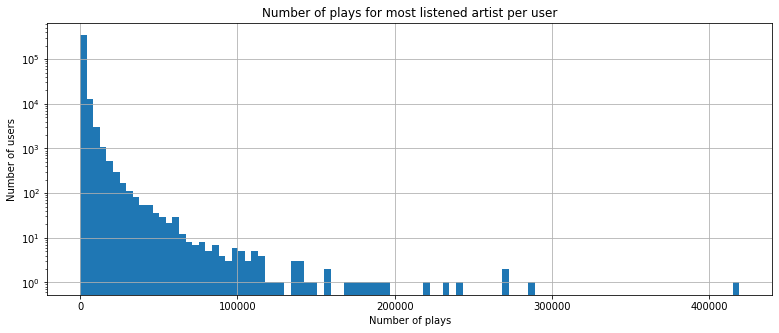

In [33]:
max_top.reset_index().hist(bins = 100, figsize = (13, 5))
plt.yscale('log')
plt.title('Number of plays for most listened artist per user')
plt.xlabel('Number of plays')
plt.ylabel('Number of users')

In [34]:
top_data[top_data['Plays'] == top_data['Plays'].max()]

,ID,Artist_ID,Artist,Plays
9654928,8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,dcaa4f81-bfb7-44eb-8594-4e74f004b6e4,nofx,419157


Most user can be found at the start of scale (notice the logY scale), but some users are truly amazing, with the max plays sitting at 419157. After some research, nofx, the artist this user has been listening to, mainly makes music of about 2 minutes, still this user has more or less listened to 1.6 years of nofx in about 4 years. We really suspect that this is due to a bot. To not have this kind of biases, we argue that taking the number of users listening to an artist is more representative of its fame in the corresponding country

In [35]:
top_user[top_user['ID'] == '8d0384537845e7f2b1b8b3e8a9f67eb8d9439794']

,ID,Gender,Age,Country,Registered
197654,8d0384537845e7f2b1b8b3e8a9f67eb8d9439794,m,31.0,Austria,"Nov 11, 2005"


### Creating our dataset we'll use for the different predictions method

In [36]:
top_merged = top_data.merge(top_user, left_on='ID', right_on='ID')
top_merged = top_merged.drop(columns=['Artist_ID', 'Registered'])

In [37]:
k = 500
topk_users = top_merged.groupby('ID').size().sort_values(ascending = False)[0:k]

In [38]:
subset = top_merged[top_merged.ID.isin(topk_users.index)]

In [39]:
subset

,ID,Artist,Plays,Gender,Age,Country
10805,0028a632f13bc492a040e5fcb011e99992b811f6,zbigniew preisner,1450,m,24.0,Slovenia
10806,0028a632f13bc492a040e5fcb011e99992b811f6,sophie zelmani,457,m,24.0,Slovenia
10807,0028a632f13bc492a040e5fcb011e99992b811f6,tindersticks,450,m,24.0,Slovenia
10808,0028a632f13bc492a040e5fcb011e99992b811f6,tegan and sara,322,m,24.0,Slovenia
10809,0028a632f13bc492a040e5fcb011e99992b811f6,jan a.p. kaczmarek,318,m,24.0,Slovenia
...,...,...,...,...,...,...
16980014,ff9d855523b290088795f2ff22155353b9dc092f,the cure,1,f,NaN,United States
16980015,ff9d855523b290088795f2ff22155353b9dc092f,the dead texan,1,f,NaN,United States
16980016,ff9d855523b290088795f2ff22155353b9dc092f,the magnetic fields,1,f,NaN,United States
16980017,ff9d855523b290088795f2ff22155353b9dc092f,the modern lovers,1,f,NaN,United States


# Computing Prediction

### Predicting only based on the user average listens

Trivially predict the mean of the user: $\large pred(u,i) = \mu_{u} = \sum_{k \in I(u)} \frac{Plays(u, k)}{|I(u)|}$

where, $u$ is the usere we're making the prediction for, $i$ is the artist we want to predict the number of plays, $I(u)$ is the set of Artist the user has listened to.

Have still to measure the performance ? How?

In [40]:
def compute_pred_avg_user(user, artist_i, avg_listens):
    return int(avg_listens[avg_listens['ID'] == user]['Plays'])

### Predicting only based on the artist average listens


Trivially predict the mean of the artist for each user: $\large pred(u,i) = \mu_{i} =\sum_{v \in U(i)} \frac{Plays(v,i)}{|U(i)|}$

where $U(i)$ is the set of users that has listened artist i



In [41]:
def compute_pred_avg_artist(user, artist_i, avg_listens):
    prediction = avg_listens[avg_listens['Artist'] == artist_i]
    if len(prediction) == 0: 
        return int(avg_listens['Plays'].mean()) # What to return when we haven't seen the artist?
    else:
        return int(prediction['Plays'])

###  Using User similarity

**First idea**: Compute similarity based on Jaccard distance: Each user has a set of artist he has listened to.

$\large sim(u,v)$ = Jacc$(I(u), I(v))$ = $\Large \frac{|I(u) \cap I(v)|}{|I(u) \cup I(v)|}$

Once we have this similarity, check if a new artist will be listened a lot by the user by comparing it to all the other users that have listened to him, this is the user-specific sum : 

$\large p(u, i) = \frac{\sum_{v \in U(i)} sim(u,v) \cdot Plays(v,i)}{ \sum_{v \in U(i)} sim(u,v)}$

where $U(i)$ is the set of users that have listened to the group $i$

In [42]:
group = subset[['ID','Artist']].groupby('ID').agg(set)
matrice = np.zeros((len(group), len(group)))

def compute_sim_users_artist(user_set):
    matrice = np.zeros((len(user_set), len(user_set)))
    mapping = {}
    
    for i in range(len(matrice)):
        print(i)
        mapping[user_set.iloc[i].name] = i
        for j in range(i+1, len(matrice[i])):
            matrice[i,j]=len((user_set.iloc[i].Artist.intersection(user_set.iloc[j].Artist)))/len(user_set.iloc[i].Artist.union(user_set.iloc[j].Artist))
    return matrice, mapping

In [43]:
#Technique is too slow
user_sim, mapping = compute_sim_users_artist(group)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, 'User non-zero similarity distribution')

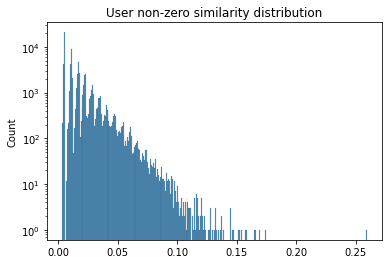

In [44]:
len(user_sim)
values = user_sim[np.where(user_sim != 0)]

sns.histplot(values.flatten())
plt.yscale("log")
plt.title("User non-zero similarity distribution")

In [45]:
def compute_pred_sim_users(user, artist, user_has_artist, sim_matrix, df):
    user_id = mapping[user]
    num = 0
    denom = 0
    for i in user_has_artist:
        
        if mapping[i] < user_id: ## Our matrice of similarities is a upper triangular one
            num += int(df[(df['Artist'] == artist)
                               & (df['ID'] == i)]['Plays']) * sim_matrix[mapping[i], user_id]
            denom += sim_matrix[mapping[i], user_id]
        
        else:
            num += int(df[(df['Artist'] == artist)
                               & (df['ID'] == i)]['Plays']) * sim_matrix[user_id, mapping[i]]
            denom += sim_matrix[user_id, mapping[i]]
        
    if denom == 0:
        return 0
    else:
        return int(num/denom)

**Second idea**: Add user specific mean in the prediction

Previously we do not consider at all the user, we just find the users that rate this item. We try to integrate this in this method:

We will use the user-specific sum:
$\large \tilde{u} =  \frac{\sum_{v \in U(i)} sim(u,v) \cdot (Plays(v,i) - \mu_{v})}{ \sum_{v \in U(i)} sim(u,v)} $

Then we compute: 

$\large p(u, i) = \mu_{u} + \tilde{u} $


In [46]:
def compute_pred_user_item(user, artist, df):
    user_artists = set(df[df['ID'] == user]['Artist'])
    artist_has_user = set(df[(df['Artist'] == artist) & (df['ID'] != user)]['ID'])
    
    num = 0
    denom = 0
    
    for i, x in enumerate(artist_has_user):
        user_i_artists = set(df[df['ID'] == x]['Artist'])
        sim_with_i = len(user_artists.intersection(user_i_artists))/len(user_artists.union(user_i_artists))
        
        num += sim_with_i * (int(df[(df['ID'] == x) & (df['Artist'] == artist)]['Plays']) - int(df[df['ID'] == x]['Plays'].mean()))
        denom += sim_with_i
    
    if denom == 0:
        return df[df['ID'] == user]['Plays'].mean()
    else:
        return df[df['ID'] == user]['Plays'].mean() + num/denom
    
    
    

    

## Measurement of the quality of the individual recommendation

In [60]:
#Splits the dataframe into a train and a test set randomly
def split_train_test(df, train_size = 0.9 ,seed = 42, apply_seed = False):
    uniques_ids = df.ID.unique()
    if apply_seed:
        np.random.seed(seed)
    train = pd.DataFrame()
    test = pd.DataFrame()
    
    for user_id in uniques_ids:
        user_sub = df[df['ID'] == user_id]
        randomization = np.random.permutation(user_sub.index)
        user_sub_train = user_sub.loc[randomization[0:int(len(randomization)*train_size)]]
        user_sub_test = user_sub.loc[randomization[int(len(user_sub)*train_size):len(user_sub)]]
        
        train = train.append(user_sub_train)
        test = test.append(user_sub_test)
    
    return train, test


Computes just mean absolute error

In [48]:
def compute_mae(pred_method, helper_df):
    mae = 0
    for i, row in test.iterrows():
        user = row.ID
        artist = row.Artist
        prediction = pred_method(user, artist, helper_df)
        mae += abs(row.Plays - prediction)
    return mae/len(test)

Computes accuracy, precision and recall

In [49]:
def compute_appreciation(pred_method, helper_df, user_specific_threshold = None, threshold = 100):
    predictions = np.zeros(len(test))
    reals = np.zeros(len(test))
    indice = 0
    for i, row in test.iterrows():
        user = row.ID
        artist = row.Artist
        prediction = pred_method(user, artist, helper_df)
        predictions[indice] = prediction > threshold
        reals[indice] = row.Plays > threshold
        indice += 1
    
    tp = np.sum(np.bitwise_and(predictions==1, reals == 1))
    tn = np.sum(np.bitwise_and(predictions==0, reals == 0))
    
    fn = np.sum(np.bitwise_and(predictions== 0, reals == 1))
    
    acc = np.sum(predictions == reals)
    
    return acc/len(test), tp/(tp+tn), tp/(tp + fn)

Computes mae, accuracy, precision and recall in one go

In [50]:
def compute_mae_and_app(test_df, pred_method,helper_df, threshold = 100):
    predictions = np.zeros(len(test_df))
    reals = np.zeros(len(test_df))
    indice = 0
    mae = 0
    for i, row in test_df.iterrows():
        user = row.ID
        artist = row.Artist
        prediction = pred_method(user, artist, helper_df)
        mae += abs(row.Plays - prediction)
        predictions[indice] = prediction > threshold
        reals[indice] = row.Plays > threshold
        indice += 1
    
    tp = np.sum(np.bitwise_and(predictions==1, reals == 1))
    tn = np.sum(np.bitwise_and(predictions==0, reals == 0))
    
    fn = np.sum(np.bitwise_and(predictions== 0, reals == 1))
    
    acc = np.sum(predictions == reals)
    
    return mae/len(test_df), acc/len(test_df), tp/(tp+tn), tp/(tp + fn)

## Measuring on 10 rounds and generating plots according to method

In [ ]:
def compute_n_rounds(pred_method, nb_users_selected = 500, n = 10, seed = 42):
    """
    Computes the mae, accuracy, precision and recall on n round of the pred_method
    
    pred_method = method that allows to compute the prediction
    nb_users_selected = number of users in the sub-sample
    n = number of rounds
    seed = seed for random generation of sub-samples
    """
    np.random.seed(seed)
    maes, accs, precs, recs = [],[],[],[]
    nb_users = len(top_merged.groupby('ID'))
    
    for i in range(n):
        selected_users = np.random.randint(0, nb_users, nb_users_selected) #Generate a random list of nb_users_select users
        subset_500_users = top_merged.groupby('ID').size()[selected_users]
        subset = top_merged[top_merged.ID.isin(subset_500_users.index)]
        train, test = split_train_test(subset, train_size=0.95)

        if pred_method == compute_pred_avg_user:
            avg_user_listens = train.groupby("ID").mean('Plays').reset_index()
            mae, acc, prec, rec = compute_mae_and_app(test, pred_method, avg_user_listens)

        elif pred_method == compute_pred_avg_artist:
            avg_artist_listens = train.groupby("Artist").mean('Plays').reset_index()
            mae, acc, prec, rec = compute_mae_and_app(test, pred_method, avg_artist_listens)
        else:
            mae, acc, prec, rec = compute_mae_and_app(test, pred_method, train) #sim measures doesn't a helper set
        
        maes.append(mae)
        accs.append(acc)
        precs.append(prec)
        recs.append(rec)
        
    return maes, accs, precs, recs

    

In [ ]:
start = time.time()
maes_users, accs_users, precs_users, recs_users = compute_n_rounds(compute_pred_avg_user)
maes_artists, accs_artists, precs_artists, recs_artists = compute_n_rounds(compute_pred_avg_artist)
between = time.time()
maes_user_item, accs_user_item, precs_user_item, recs_user_item = compute_n_rounds(compute_pred_user_item)
end = time.time()

In [ ]:
print(end-start)
print(end-between)

In [ ]:
maes_to_plot = pd.DataFrame(columns = ['User_avg', 'Artist_avg', 'Similarity'])
accs_to_plot = pd.DataFrame(columns = ['User_avg', 'Artist_avg', 'Similarity'])
precs_to_plot = pd.DataFrame(columns = ['User_avg', 'Artist_avg', 'Similarity'])
recs_to_plot = pd.DataFrame(columns = ['User_avg', 'Artist_avg', 'Similarity'])

for i in range(len(maes_users)):
    mae_entry = {'User_avg':maes_users[i], 'Artist_avg':maes_artists[i], 'Similarity':maes_user_item[i]}
    acc_entry  = {'User_avg':accs_users[i], 'Artist_avg':accs_artists[i], 'Similarity':accs_user_item[i]}
    prec_entry  = {'User_avg':precs_users[i], 'Artist_avg':precs_artists[i], 'Similarity':precs_user_item[i]}
    rec_entry  = {'User_avg':recs_users[i], 'Artist_avg':recs_artists[i], 'Similarity':recs_user_item[i]}
    maes_to_plot = maes_to_plot.append(mae_entry, ignore_index = True)
    accs_to_plot = accs_to_plot.append(acc_entry, ignore_index = True)
    precs_to_plot = precs_to_plot.append(prec_entry, ignore_index = True)
    recs_to_plot = recs_to_plot.append(rec_entry, ignore_index = True)

In [ ]:
sns.barplot(data=maes_to_plot)

In [ ]:
sns.barplot(data = accs_to_plot)

In [ ]:
sns.barplot(data = precs_to_plot)

In [ ]:
sns.barplot(data = recs_to_plot)

### Measurment of the quality of the group recommender systems:

First we need a way to generate groups:
We want groups that have the most artists in common. As this is a NP hard problem (Finding the optimal set of clusters in a graph), we create our groups using a greedy approach where at each iteration we try to add the user in the group that maximizes the set of artists.
For our mesurments, we want to try to get at least 5 artists in common for each groups

In [51]:
def get_user_groups(df):
    user_artists = df[['ID', 'Artist']].groupby('ID').agg(set) 
    all_max_groups= [] #List of the max groups
    for user1_ID, user1_artists in user_artists.iterrows():
        max_group = ([user1_ID], user1_artists.Artist) #Start with the user and try to add other users in the group
        flag = True
        while(flag):
            max_group, flag = maximize_set(max_group, user_artists)
        
        users = sorted(max_group[0])
        artists = sorted(max_group[1]) #Converts arg to list => We do this step of sorting to only get the group once
        max_group = (users, artists)
        if max_group not in all_max_groups:#Allows to not have duplicated groups
            all_max_groups.append(max_group)
        
    return all_max_groups

def maximize_set(max_group, user_artists):
    max_set = set()
    for user2_ID, user2_artists in user_artists.iterrows(): 
        if(user2_ID not in max_group[0]): #Go through all the user that are not already in the group
            new_set = max_group[1].intersection(user2_artists.Artist) 
            if(len(new_set) > len(max_set) and len(new_set) > 5): #keeps the biggest new set & nb_artists > 5
                max_set = new_set
                new_user_in_group = user2_ID
    
    if(len(max_set) == 0):
        return (max_group[0], max_group[1]), False
    
    max_group[0].append(new_user_in_group)
    return (max_group[0], max_set), True
        

In [52]:
import time
start = time.time()
groups = get_user_groups(subset)
end = time.time()
print(f"Time needed : {end-start}")

Time needed : 60.439040660858154


In [53]:
def get_group_recommendation_according_to_our_algorithm(users, same_artists, df, threshold = 100):
    recommendations = pd.DataFrame(columns = ["Artist", "nb_likes"])
    for artist in same_artists:
        nb_likes = 0
        for user in users:
            if df[(df['ID'] == user) & (df['Artist'] == artist)].iloc[0]['Plays'] > threshold:
                nb_likes += 1
        recommendations = recommendations.append({"Artist": artist, "nb_likes" : nb_likes}, ignore_index = True)
    return recommendations.sort_values("nb_likes", ascending=False).reset_index().drop(columns = ['index'])
    

In [54]:
def test_recommander(pred_method, df, helper_df, group_of_users, same_artists, threshold = 100):
    
    list_of_artists = dict()
    
    for user in group_of_users:
        nb_likes = 0
        for artist in df[(df['ID'] == user) & (df['Artist'].isin(same_artists))]['Artist']:
            list_of_artists[artist] = 0
        
    for artist in list_of_artists.keys():
        for user in group_of_users:
            nb_plays = get_nb_plays(user, artist, df)
                
            if nb_plays != -1:
                if nb_plays > threshold:
                    list_of_artists[artist] += 1
            
            else:
                prediction = pred_method(user, artist, helper_df)
                if prediction > threshold:
                    list_of_artists[artist] += 1
    
    recommendation = pd.DataFrame(columns = ["Artist", "nb_likes"])
    
    for entry in list_of_artists:
        recommendation = recommendation.append({"Artist":entry, "nb_likes":list_of_artists[entry]}, ignore_index = True)
    
    return recommendation.sort_values("nb_likes", ascending = False).reset_index().drop(columns = "index")

def get_nb_plays(user, artist, df):
    res = df[(df['ID'] == user) & (df['Artist'] == artist)]
    if len(res) == 0:
        return -1
    else:
        return res.iloc[0]['Plays']
    

In [73]:
def get_quality_of_group_recommendation(pred_method, groups):
    dcg_idcg = []
    for id_artists in groups:
        users = id_artists[0]
        same_artists = id_artists[1][0:5]#Take the first 5
        
        
        reals = get_group_recommendation_according_to_our_algorithm(users, same_artists, subset)  
        
        
        if(pred_method == compute_pred_avg_user):
            preds = test_recommander(pred_method, subset, avg_user_listens, users, same_artists)
        elif(pred_method == compute_pred_avg_artist):
            preds = test_recommander(pred_method, subset, avg_artist_listens, users, same_artists)
    
    
        reals['Rank'] = [i for i in range(1, len(reals)+ 1)]
        preds['Rank'] = [i for i in range(1, len(reals)+ 1)] #Not same rank for items rated equally
        final = reals.merge(preds, on = 'Artist')

        log_ranks_pred = np.log2(f['Rank_y'])
        log_ranks_pred = log_ranks_pred.where(log_ranks_pred > 0, 1)

        log_ranks_real = np.log2(f['Rank_x'])
        log_ranks_real = log_ranks_real.where(log_ranks_real > 0, 1)

        DCG = np.sum(final['nb_likes_x']/log_ranks_pred)
        IDCG = np.sum(final['nb_likes_x']/log_ranks_real)
        
        if IDCG == 0: #Case nobody has liked anything
            dcg_idcg.append(1.0)
        else:
        dcg_idcg.append(DCG/IDCG)
    
    return dcg_idcg
    

## Generate all things

In [84]:
def dcg_idcg(reals, preds):
    reals['Rank'] = [i for i in range(1, len(reals)+ 1)]
    preds['Rank'] = [i for i in range(1, len(reals)+ 1)] #Not same rank for items rated equally
    final = reals.merge(preds, on = 'Artist')
    log_ranks_pred = np.log2(final['Rank_y'])
    log_ranks_pred = log_ranks_pred.where(log_ranks_pred > 0, 1)
    log_ranks_real = np.log2(final['Rank_x'])
    log_ranks_real = log_ranks_real.where(log_ranks_real > 0, 1)
    DCG = np.sum(final['nb_likes_x']/log_ranks_pred)
    IDCG = np.sum(final['nb_likes_x']/log_ranks_real)
    if IDCG == 0: #Case nobody has liked anything
        return 1.0
    return DCG/IDCG

In [85]:
def compute_group_and_single_recommendation_for_all(nb_users_selected = 500, n = 10, seed = 42):
    np.random.seed(seed)
    maes, accs, precs, recs = [],[],[],[]
    nb_users = len(top_merged.groupby('ID'))
    all_dcgs = []
    for i in range(n):
        print(f"=== EPOCH {i}===")
        selected_users = np.random.randint(0, nb_users, nb_users_selected)
        print(selected_users)
        subset_500_users = top_merged.groupby('ID').size()[selected_users]
        subset = top_merged[top_merged.ID.isin(subset_500_users.index)]
        train, test = split_train_test(subset, train_size=0.95)
        
        
        avg_user_listens = train.groupby("ID").mean('Plays').reset_index() # Needed for the average user pred
        avg_artist_listens = train.groupby("Artist").mean('Plays').reset_index() #Needed for the average artists pred
        
        print("Started predicting")
        mae1, acc1, prec1, rec1 = compute_mae_and_app(test, compute_pred_avg_user, avg_user_listens)
        mae2, acc2, prec2, rec2 = compute_mae_and_app(test, compute_pred_avg_artist, avg_artist_listens)
        
        mae3, acc3, prec3, rec3 = compute_mae_and_app(test, compute_pred_user_item, train)
        
        maes.append([mae1,mae2,mae3]) #Adding like this to then use easily a dataframe
        accs.append([acc1,acc2,acc3])
        precs.append([prec1,prec2, prec3])
        recs.append([rec1,rec2,rec3])
        
        print("Starting group step")
        
        groups = get_user_groups(subset)
        print("Finished forming the groups")
        
        at_least_5_users = [] #Keeping only the groups with at least 5 users.
        for group in groups:
            if(len(group[0])> 4):
                at_least_5_users.append(group)
        
        dcgs = []
        for id_artists in at_least_5_users:
            users = np.array(id_artists[0])
            same_artists = id_artists[1][0:5] #Take the first 5
            reals = get_group_recommendation_according_to_our_algorithm(users, same_artists, subset) #What should be recommended
            
            preds_user = test_recommander(compute_pred_avg_user, subset, avg_user_listens, users, same_artists)
            preds_artist = test_recommander(compute_pred_avg_artist, subset, avg_artist_listens, users, same_artists)
            preds_sim = test_recommander(compute_pred_user_item, subset, subset, users, same_artists)
            
            dcg_users = dcg_idcg(reals, preds_user)
            dcg_artists = dcg_idcg(reals, preds_artist)
            dcg_sim = dcg_idcg(reals, preds_sim)
            
            dcgs.append([dcg_users, dcg_artists, dcg_sim])
        all_dcgs.append(dcgs)  
        
        
    return maes, accs, precs, recs, all_dcgs


In [58]:
import time

In [86]:
start = time.time()
maes, accs, precs, recs, all_dcgs = compute_group_and_single_recommendation_for_all(nb_users_selected = 500, n = 10)
end = time.time()
print(f"Time{end-start}")
print(maes)
print(accs)
print(precs)
print(recs)
print(all_dcgs)

=== EPOCH 0===
[121958 146867 131932 259178 119879 110268 207892  54886 137337  87498
 175203 191335 278167  41090 329365  64820 262913 321879 194027 327069
 252709 199041 267455 103355 235796 214176 184779 347449 258795 156730
 346622 149503 130523   2747 123855  65725 129981  84654  67435 319030
 328947  31551 273538 331236   3890  41606 256840 349457 141699 270936
 239931 239629 205041 174073 207624  68148 252801 124243 251995 154555
  48555 256508 279303 106530  80077 298064 200551 281601 208261 240181
 341097 315139 171829 271836 202283 196769  37065 223165  99299  11534
  40397 257750 353531 263160  55591 220884  23247  24300  82798   9268
 348951 274329 194776 217851 236584  38044 313358  48984 302918 264712
 120151 133767 124375 179262 136330 301648 164231  13986  61858 129312
  12666 300804 134633 288998 326649 104488 183323 284806 270536  30535
 314400 351279 297366  77373 123684 273109  24538 201664 139182 158338
 184064 214020  98806  90982 121626 119176 218126 218969 12240

Started predicting
Starting group step
Finished forming the groups
=== EPOCH 3===
[157791  87597 312752   2830  74800 170719  72709  50230 341967  31563
 252942 168458 169335   4914 218788 351416 311383 317170  17472 129005
  59582 248869 247157 316056 100731 165924 140002 101303 292091 159598
 192522  20813 231842  96493 279408 258217 325190 155406 224404 308724
  55889  94729 168876 172471 346110 189301 212573 137585  27432  99197
 257434  26061 296317 236479 214121 306033  91585 318009  35295 212945
 121713 246228 170349 174858  70557 260031 214910 172370 294063 243805
 266594 349251  16629 317091 342777 320474  90758 185527 159955 273944
 245605 193531 268983 172880 325613 222692  28617 250027 148330  11878
  99634 324070  67309 124907 221083 265897   1444   6630  57125 325723
  37532 317932  93255 353356 174884  75266 193869  19167 285654 312056
 104524 247272 112689 328340 333930 204574  14833 205830 279352 125219
 234837 143060 198332 190954  71756  78789  67867 147103 285516 27

Started predicting
Starting group step
Finished forming the groups
=== EPOCH 6===
[174556 290521  72826 200340 108434  99567 108710 136206 323379 190586
  38057 303421  59578  26097 205744 142750  89370 350214 232392 228030
 136592 266048  91882 287036   6801 350252  33708 147987 254137 193585
 184485 300684 255100 259557 125095  23729 185280 139211  18976 209662
 155711 243821 272804 305163 157268  32065 115717 222527 229871 279297
 115455  81274 142038  13794 275438  92593 106303 182373 187897  34576
 303044  57353  71550 188277  61598 340674 196566 328862  14128 314080
 342422   4590  85527  95807  43829  43847 325692 266616 175118 206543
   9557 281348  88229 192412 213701 122378 247246  94179  14919  13472
  19967 322095   8407 228767  62067 327831  76370 351894 288245   4142
  31217 119640 193680 184439 295282 132918 183846 300777 145808 313462
 179611 295192  73054 284007 241617 230896  21870  63691 345126  10190
  70625 214338 194868 201245 355566 235620 138306 352465 304508 13

Started predicting
Starting group step
Finished forming the groups
=== EPOCH 9===
[ 21316 162799 106472  79368 294278 245555  44945 351956 130048 233855
 337325  50817 307287 143167  54320  23906 130358 155941 283848  50682
 324238   7863   4702 213256 182757 316575 132115 307604 155290 278203
  19274 222990 219143 260667 251622  16548 279699   5118 270704  11894
 121737 208009 213167  77336 157337 143096  84467 313438  61218 155270
 315445 128443 186884 163660 322819  56809  19978 313500  28039     48
 252714 105313 346769 180536  38064 131345 242028 228247 328866 163645
  68960 330833 144350 127532  66588  91152  48501 296791  12738 140790
 215076 336183  57656 103153 165199 317798 133889   7796 351984 161196
  39914 123503  74170 162928 146571 342416 258657 214849 186583  99360
  58766 117348  59563 160179  95364 124609 333996 281140 110448 315008
  37397 162563 109703 158607 168591 272171 346476  39331 120286 285293
 353210 242827 166107 181101 293839  55226  66044  36172  74398 24

In [87]:
maes_to_plot = pd.DataFrame(maes, columns = ['User_avg', 'Artist_avg', 'Similarity'])
accs_to_plot = pd.DataFrame(accs, columns = ['User_avg', 'Artist_avg', 'Similarity'])
precs_to_plot = pd.DataFrame(precs, columns = ['User_avg', 'Artist_avg', 'Similarity'])
recs_to_plot = pd.DataFrame(recs, columns = ['User_avg', 'Artist_avg', 'Similarity'])


In [88]:
maes_to_plot

,User_avg,Artist_avg,Similarity
0,124.752055,217.235616,166.383170
1,142.414030,241.883769,169.589664
2,119.370090,206.597519,154.632251
3,123.344398,226.186030,161.306169
4,147.908966,223.898700,183.483845
5,140.200412,221.899108,179.228139
6,126.623715,212.719671,167.554708
7,126.057971,223.091787,175.076549
8,137.651755,237.693737,169.507685
9,123.847107,218.993802,175.960880


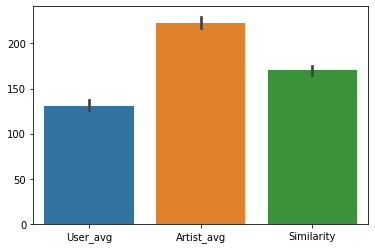

In [89]:
sns.barplot(data=maes_to_plot)

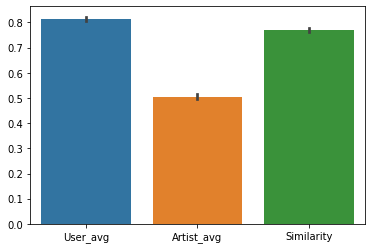

In [90]:
sns.barplot(data=accs_to_plot)

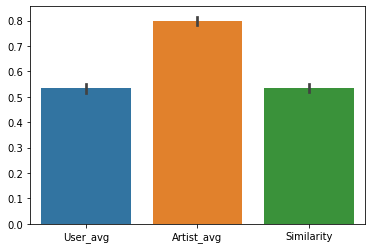

In [91]:
sns.barplot(data=precs_to_plot)

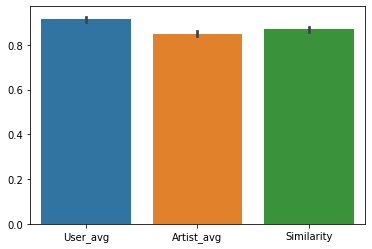

In [92]:
sns.barplot(data=recs_to_plot)

In [ ]:
def recommander(pred_method, df, hepler_df, group_of_users, threshold = 100):
    list_of_artists = dict()
    for user in group_of_users:
        nb_likes = 0
        for artist in df[df['ID'] == user]['Artist']:
            list_of_artists[artist] = 0
    
    
    print(list_of_artists.keys())
    for artist in list_of_artists.keys():
        for user in group_of_users:
            nb_plays = get_nb_plays(user, artist, df)
            
            if nb_plays != -1:
                if nb_plays > threshold:
                    list_of_artists[artist] += 1
            
            else:
                prediction = pred_method(user, artist, helper_df)
                if prediction > threshold:
                    list_of_artists[artist] += 1
    
    recommendation = pd.DataFrame(columns = ["Artist", "nb_likes"])
    
    for entry in list_of_artists:
        recommendation = recommendation.append({"Artist":entry, "nb_likes":list_of_artists[entry]}, ignore_index = True)
    
    return recommendation.sort_values("nb_likes", ascending = False).reset_index().drop(columns = "index")
